# Sentiment Analysis: approximating Word2Vec results with SPPMI-SVD

# Introduction


Introduced by Mikolov et al. in two papers in 2013 ([[1]](#References) and [[2]](#References)), Word2Vec is a widely popular way of getting vector representation for words. The core assumption of Word2Vec is that if two words are used in similar contexts, then they should share a similar meaning and vector representation. These vector representations can then be used in clustering a set of documents or in text classification tasks.

In 2014, Omer Levy and Yoav Goldberg ([[3]](#References)) demonstrated that Word2Vec could be approximated by "factorizing a word-context matrix whose cells are the pointwise mutual information (PMI) of the respective word and context pairs". Unlike Word2Vec which is based on a neural-network and uses gradient descent, Omer Levy and Yoav Goldberg method only relies on word count, information theory and the factorization of a matrix with the well-known Singular Value Decomposition. They also go on and show that this method produces word embeddings that can achieve comparable performance as the ones from Word2Vec.

In this notebook, I wanted to compare the performance of [Gensim's](https://radimrehurek.com/gensim/models/word2vec.html) famous implementation of Word2Vec and my own implementation of Omer Levy and Yoav Goldberg model on a Sentiment Analysis tasks.

### Environment
`python==3.7`<br>
`spacy==2.0.12`<br>
`nltk==3.4.4`<br>
`tqdm=4.32.1`<br>
`scikit-learn==0.21.2`<br>
`gensim==0.21.2`<br>


In [1]:
import os
import pickle
import logging
import pandas as pd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s",
                    datefmt= '%H:%M:%S', level=logging.INFO)
import spacy 
from nltk.tokenize import TweetTokenizer
from tqdm.auto import tqdm
tqdm.pandas(desc="progress-bar")

# Getting the Data


The data comes from **Ahmed Besbes** *Sentiment Analysis on twitter using word2vec and keras* blog post 
[[4]](#References). You can find the data [here](https://drive.google.com/uc?id=0B04GJPshIjmPRnZManQwWEdTZjg&export=download).

The data consists of more than a million of tweet, each tweet comes with its content / text and a binary sentiment score (positive / negative feeling).

Loading the data:

In [2]:
df_tweets = pd.read_csv("training.1600000.processed.noemoticon.csv",
                        encoding="ISO-8859-1", header=None)

Keeping only the text of the tweets (`msg`) and the sentiment score associated with them (`sentiment`):

In [3]:
df_tweets = df_tweets[[0, 5]]
df_tweets.columns = ['sentiment', 'msg']
df_tweets['sentiment'] = df_tweets['sentiment'].map({4: 1, 0: 0}) # Mapping 4 to 1

In [4]:
df_tweets.head()

,sentiment,msg
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
df_tweets.shape

(1600000, 2)

We have **1,600,000 tweets**.

Negative sentiment example:

In [6]:
df_tweets[df_tweets['sentiment'] == 0]['msg'][26]

'Just going to cry myself to sleep after watching Marley and Me.  '

Positive sentiment example:

In [7]:
df_tweets[df_tweets['sentiment'] == 1]['msg'][1599995]

'Just woke up. Having no school is the best feeling ever '

Let's see the distribution of the classes:

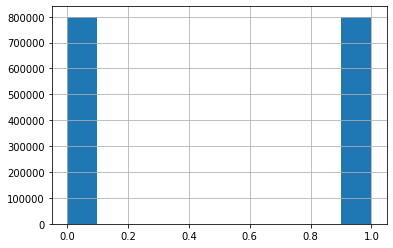

In [8]:
df_tweets['sentiment'].hist()

In [9]:
df_tweets['sentiment'].value_counts()

1    800000
0    800000
Name: sentiment, dtype: int64

Perfectly balanced dataset. ("...As all things should be." - Thanos)

Let's have a look at the number of words in each tweets:

In [10]:
df_len = df_tweets['msg'].str.split().str.len()
print("min #words: {}".format(df_len.min()))
print("avg #words: {}".format(round(df_len.mean())))
print("max #words: {}".format(df_len.max()))

min #words: 1
avg #words: 13
max #words: 64


# Light Preprocessing 
Now, let's do some light preprocessing. We are going to remove hyperlinks, hashtags, and mentions in the tweets, as these do not provide much information for our sentiment analysis task. We will also lowercase the tweets to reduce the size of the vocabulary:

In [11]:
def tokenizer(tweet):
    tokens = TweetTokenizer(preserve_case=False,
                            reduce_len=True,
                            strip_handles=True).tokenize(tweet)
    tokens = filter(lambda t: not t.startswith('#'), tokens)
    tokens = filter(lambda t: not t.startswith('http'), tokens)
    return ' '.join(tokens)

Here's an example of the `tokenizer()` function in action:

In [12]:
print('Before preprocessing:')
print(df_tweets['msg'][0])
print()
print('After preprocessing:')
print(tokenizer(df_tweets['msg'][0]))

Before preprocessing:
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D

After preprocessing:
- awww , that's a bummer . you shoulda got david carr of third day to do it . ;D


Now let's clean-up all the tweets:

In [13]:
t = time()
df_tweets['clean'] = df_tweets['msg'].progress_map(tokenizer) 
print("{} mins".format(round((time() - t) / 60)))


4 mins


# Creating the training & testing sets 

In [14]:
from sklearn.model_selection import train_test_split

### Looking at the preprocessing results

How many tweets became empty strings after the preprocessing?

In [15]:
df_tweets[df_tweets['clean'] == '']['sentiment'].shape[0]

3045

Not many, we can remove these from the training and testing sets, they won't be useful to our models.

Let's have a look at the number of words in each tweets now that we have preprocessed them:

In [16]:
df_tweets['len'] = df_tweets['clean'].str.split().str.len()
df_tweets['len'].mean()

14.718443125

We want to keep tweets long enough for the word embedding models to learn meaningful information about the words and their context.<br>
Let's see how many tweets do we have left if we keep only those with at least 10 words left once preprocessed:

In [17]:
df_tweets[df_tweets['len'] >= 10].shape

(1088998, 4)

That still leaves us plenty of tweets to work with.

Does removing empty strings and cleaned up tweets with less than 10 words unbalanced our dataset?

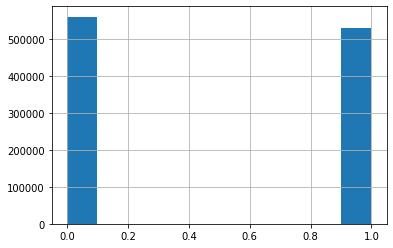

In [18]:
df_tweets[(df_tweets['clean'] != '') & (df_tweets['len'] >= 10)]['sentiment'].hist()

In [19]:
df_tweets[(df_tweets['clean'] != '') & (df_tweets['len'] >= 10)]['sentiment'].value_counts()

0    560114
1    528884
Name: sentiment, dtype: int64

In [21]:
528884 / 560114

0.9442434932888661

Once we remove empty strings and short tweets, our data set is slightly imbalanced, however by only 6%. This is unlikely to introduce much bias to our models.

In [22]:
df_sets = df_tweets[(df_tweets['clean'] != '') & (df_tweets['len'] >= 10)].copy()

In [23]:
x_train, x_test, y_train, y_test = train_test_split(df_sets['clean'],
                                                    df_sets['sentiment'],
                                                    test_size=0.2)

How many elements in the training and testing sets do we have?

In [24]:
print(x_train.shape[0], y_train.shape[0])
print(x_test.shape[0], y_test.shape[0])

871198 871198
217800 217800


Both Word2Vec and my implementation of SPPMI - SVD requires a list of list of tokens as an input:

In [25]:
sentences = x_train.str.split().tolist()

# Training the Word2Vec model

In [27]:
from gensim.models import Word2Vec # Gensim's implementation of Word2Vec

We are going to train the model with the default hyperparameters, that should give us decent enough word embeddings.<br>
Here's a breakdown of some of the hyperparameters value:
* `min_count=5`: every word with an absolute frequency below 5 is ignored
* `sample=1e-3`: word with a relative frequency above 0.001 are randomly downsampled
* `window=5`: we look at 5 context words to the left of our target word, and 5 context words to the right
* `size=100`: the dimension of the resulting word vectors
* `negative=5`: negative sampling (For more details, have a look at Chris McCormick [blog post](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/))

Training of the model:

In [28]:
t = time()
model_w2v = Word2Vec(sentences, workers=3)
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:40:07: collecting all words and their counts
INFO - 10:40:07: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 10:40:07: PROGRESS: at sentence #10000, processed 188746 words, keeping 15923 word types
INFO - 10:40:07: PROGRESS: at sentence #20000, processed 377957 words, keeping 24463 word types
INFO - 10:40:07: PROGRESS: at sentence #30000, processed 566253 words, keeping 31333 word types
INFO - 10:40:07: PROGRESS: at sentence #40000, processed 754946 words, keeping 37305 word types
INFO - 10:40:07: PROGRESS: at sentence #50000, processed 943094 words, keeping 42555 word types
INFO - 10:40:07: PROGRESS: at sentence #60000, processed 1131529 words, keeping 47426 word types
INFO - 10:40:07: PROGRESS: at sentence #70000, processed 1318966 words, keeping 52175 word types
INFO - 10:40:07: PROGRESS: at sentence #80000, processed 1505794 words, keeping 56422 word types
INFO - 10:40:07: PROGRESS: at sentence #90000, processed 1695225 words, keeping 60565 word 

INFO - 10:40:14: PROGRESS: at sentence #830000, processed 15627848 words, keeping 238737 word types
INFO - 10:40:14: PROGRESS: at sentence #840000, processed 15815588 words, keeping 240575 word types
INFO - 10:40:14: PROGRESS: at sentence #850000, processed 16004760 words, keeping 242420 word types
INFO - 10:40:14: PROGRESS: at sentence #860000, processed 16193495 words, keeping 244202 word types
INFO - 10:40:14: PROGRESS: at sentence #870000, processed 16382445 words, keeping 246027 word types
INFO - 10:40:14: collected 246248 word types from a corpus of 16405018 raw words and 871198 sentences
INFO - 10:40:14: Loading a fresh vocabulary
INFO - 10:40:14: effective_min_count=5 retains 44278 unique words (17% of original 246248, drops 201970)
INFO - 10:40:14: effective_min_count=5 leaves 16126916 word corpus (98% of original 16405018, drops 278102)
INFO - 10:40:14: deleting the raw counts dictionary of 246248 items
INFO - 10:40:14: sample=0.001 downsamples 53 most-common words
INFO - 10:

INFO - 10:41:19: EPOCH 4 - PROGRESS: at 33.66% examples, 497014 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:20: EPOCH 4 - PROGRESS: at 38.42% examples, 503828 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:21: EPOCH 4 - PROGRESS: at 43.47% examples, 513711 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:22: EPOCH 4 - PROGRESS: at 49.13% examples, 527947 words/s, in_qsize 6, out_qsize 0
INFO - 10:41:23: EPOCH 4 - PROGRESS: at 54.80% examples, 540036 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:24: EPOCH 4 - PROGRESS: at 60.82% examples, 553277 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:25: EPOCH 4 - PROGRESS: at 67.09% examples, 567057 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:26: EPOCH 4 - PROGRESS: at 73.30% examples, 578671 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:27: EPOCH 4 - PROGRESS: at 77.97% examples, 577312 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:28: EPOCH 4 - PROGRESS: at 83.95% examples, 584756 words/s, in_qsize 5, out_qsize 0
INFO - 10:41:29: EPOCH 4 - PRO

Time to train the model: 2.03 mins


Let's explore the model quickly:

* which words are closest to *tweet*, *happy*, and *sad*?

In [29]:
for x in ['tweet', 'happy', 'sad']:
    print(x)
    print(model_w2v.wv.most_similar(positive=x, topn=5))
    print()

tweet


INFO - 10:44:43: precomputing L2-norms of word weight vectors


[('reply', 0.767540454864502), ('message', 0.7159344553947449), ('twit', 0.6866358518600464), ('post', 0.678138017654419), ('text', 0.6508252620697021)]

happy
[('pleased', 0.6360591053962708), ('thrilled', 0.6244389414787292), ('happpy', 0.6203890442848206), ('thankful', 0.6077747941017151), ('blessed', 0.5924043655395508)]

sad
[('upset', 0.766880214214325), ('depressed', 0.746283233165741), ('bummed', 0.7132532000541687), ('disappointed', 0.7101408243179321), ('saddd', 0.7009017467498779)]



* How similar are *sad* and *joy*? *Sad* and *unhappy*?

In [30]:
model_w2v.wv.similarity(w1='sad', w2='joy')

0.002171792

In [31]:
model_w2v.wv.similarity(w1='sad', w2='unhappy')

0.6453774

* Which of *phone*, *iphone*, and *dentist*, is the odd-one-out?

In [90]:
model_w2v.wv.doesnt_match(['phone', 'iphone', 'banana'])

'banana'

Saving the model and the model's word vectors:

In [34]:
model_w2v.save('models\model_w2v.w2v')

INFO - 10:46:04: saving Word2Vec object under models\model_w2v.w2v, separately None
INFO - 10:46:04: not storing attribute vectors_norm
INFO - 10:46:04: not storing attribute cum_table
INFO - 10:46:06: saved models\model_w2v.w2v


In [35]:
model_w2v.wv.save_word2vec_format(fname='models\model_w2v.vectors')

INFO - 10:46:08: storing 44278x100 projection weights into models\model_w2v.vectors


# SPPMI - SVD: an alternative to Word2Vec

In the 2014 research paper by Omer Levy and Yoav Goldberg *Neural Word Embedding as Implicit Matrix Factorization* [[3]](#References), in the 2016 blog post by Sebastian Ruder *On word embeddings - Part 3: The secret ingredients of word2vec* [[5]](#References), and in the 2017 blog post of Chris Moody *Stop Using Word2Vec* [[6]](#References), an alternative to Word2Vec is outlined in order to get vector representation of words. Instead of using a shallow neural network and a cost function optimization, this approach only uses word co-occurences, information theory and matrix factorization.

In a nutshell, PMI - SVD can be summed up in 5 steps:
1. Collecting the frequency of each word in the corpus
2. Calculating the probability for word1 to been seen next to word2 (co-occurence matrix)
3. Calculating the Pointwise Mutual Information (PMI) of word1 and word2. In the information theory field, this represents how often word1 and word2 are associated together
4. Reducing the dimension of the PMI matrix with a Singular Value Decomposition.

I added some steps in my implementation of the method, namely:
1. **Minimum Count**: ignoring words below a certain frequency, if a word only appears once or twice in more than 1 million tweets, we won't be able to learn a useful embedding for it.
2. **Downsampling**: just like for Word2Vec, this step reduces the influence of higher-frequency words, such as "the", "she", "have", etc. 
3. **Shifted Positive PMI (SPPMI)**: offsetting the PMI of two words by a constant, this is equivalent to Word2Vec negative sampling. (Referenced both in Omer Levy and Yoav Goldberg research paper [[4]](#References) and in Sebastian Ruder's [blog post](http://ruder.io/secret-word2vec/index.html#shiftedpmi))

## Training a SPPMI - SVD model

This is my own implementation of a SPPMI - SVD model in python:

In [36]:
from pierre_sppmi_svd.sppmi_svd import SPPMI_SVD

Training the model with the same hyperparameters as the one used in the Word2Vec model.<br>
An explanation of the other parameters:
* `context_alpha=0.75`: How negative samples are drawn from the corpus (cf. Sebastian Ruder's [blog post](http://ruder.io/secret-word2vec/index.html#contextdistributionsmoothing)). Empirically set to 0.75 by Mikolov et al. in their 2013 paper *Distributed Representations of Words and Phrases and their Compositionality* [[2]](#References)
* `filename`: I added some built-in functions to save a model to file

In [37]:
t = time()
model_svd = SPPMI_SVD()
model_svd.train(sentences, min_count=5, sample=1e-3,
                window=5, context_alpha=0.75, negative=5,
                size=100, filename='models/model_svd')
print('Time to build the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 10:46:55: Starting the creation of the model.
INFO - 10:46:55: Starting unigrams count.
INFO - 10:46:55: PROGRESS: at sentence #0, processed 0 words, keeping 0 unique word
INFO - 10:46:57: PROGRESS: at sentence #100000, processed 64609 words, keeping 64609 unique word
INFO - 10:46:58: PROGRESS: at sentence #200000, processed 99075 words, keeping 99075 unique word
INFO - 10:46:59: PROGRESS: at sentence #300000, processed 126938 words, keeping 126938 unique word
INFO - 10:47:00: PROGRESS: at sentence #400000, processed 151425 words, keeping 151425 unique word
INFO - 10:47:01: PROGRESS: at sentence #500000, processed 173962 words, keeping 173962 unique word
INFO - 10:47:02: PROGRESS: at sentence #600000, processed 194923 words, keeping 194923 unique word
INFO - 10:47:03: PROGRESS: at sentence #700000, processed 214557 words, keeping 214557 unique word
INFO - 10:47:04: PROGRESS: at sentence #800000, processed 233210 words, keeping 233210 unique word
INFO - 10:47:05: Ending unigrams 

Time to build the model: 9.67 mins


Let's briefly explore this model as well:

* which words are closest to *tweet*, *happy*, and *sad*?

In [38]:
for x in ['tweet', 'happy', 'sad']:
    print(x)
    print(model_svd.most_similar(x))
    print()

tweet
[(0.8505446456842223, 'calling'), (0.8495776193862725, 'read'), (0.8495180397542714, 'tweets'), (0.8469429176027146, 'bye'), (0.8430300546680312, ';)')]

happy
[(0.945999497086144, 'birthday'), (0.880208664436888, 'b-day'), (0.8734960561571478, 'bday'), (0.8417066940938347, 'party'), (0.8306431474125364, "mother's")]

sad
[(0.9005389780325246, 'upset'), (0.8694543835106927, 'makes'), (0.8580330362656811, 'cool'), (0.8569899488119206, 'bad'), (0.8516815302520757, 'very')]



* How similar are *sad* and *joy*? *Sad* and *unhappy*?

In [39]:
model_svd.similarity('sad', 'joy')

0.615120747879863

In [40]:
model_svd.similarity('sad', 'unhappy')

0.5916505460246356

Looking at the similarities and synonyms, SPPMI - SVD doesn't seem to do as well a job as Word2Vec. We will see if the word embeddings we obtained with SPPMI - SVD can still be used for Sentiment Analysis.

Let's save the vectors into file:

In [41]:
model_svd.save_vectors()

INFO - 10:57:44: Saved 246248 word vector under models/model_svd.vectors


# Creation of spaCy models from our word vectors

We are using [spaCy](https://spacy.io/api/cli#init-model) to create easy and intuitive word-vector models. One advantage of using our word vectors through spaCy-like models, is that spaCy model API automatically averages the word vectors of a sentence for us.

In [44]:
def create_spacy_model(filename):
    """ Creates spaCy model out of a model's word vectors. """
    command = 'python -m spacy init-model en {} --vectors-loc {}.vectors'.format(filename, filename)

    print('Starting command \'' + command + '\'')
    res = os.system(command)

    if res == 0:
        print('Completed with exit code {}'.format(res))
    else:
        print('Completed in error with exit code {}'.format(res))
        raise Exception('Bad exit code')

* spaCy model for Word2Vec:

In [45]:
create_spacy_model('models\model_w2v')

Starting command 'python -m spacy init-model en models\model_w2v --vectors-loc models\model_w2v.vectors'
Completed with exit code 0


In [46]:
w2v = spacy.load('models\model_w2v')

In [47]:
w2v('I feel sad').vector

array([ 4.9360871e-01, -4.0373829e-01, -7.3135686e-01,  6.7814432e-02,
        3.2670039e-01, -3.6968055e-01,  4.2483974e-01,  6.0680234e-01,
        2.7229679e-01,  7.5300694e-02, -9.3267995e-01,  1.1516744e+00,
       -2.1599710e-01,  9.2498976e-01, -8.6214191e-01,  1.4533650e+00,
        1.8456541e+00,  4.0709034e-01,  4.8833296e-01,  8.5335189e-01,
        5.8849347e-01,  6.3176751e-01,  3.0086210e-01, -8.8955039e-01,
       -2.3232644e+00, -6.7330527e-01,  1.3408600e+00, -1.7199874e-02,
       -9.6941453e-01, -7.6843578e-01, -1.3020439e+00,  6.4063293e-01,
        2.6226482e-01,  6.3013635e-03, -2.2732913e-03, -1.5816294e+00,
       -2.3162031e-01, -6.4014089e-01,  1.9306637e+00, -2.3000325e-01,
        1.3733950e+00,  5.4681206e-01, -7.0206547e-01,  4.7222617e-01,
        1.9982543e+00, -7.7410140e-03, -1.9335833e+00, -8.3441615e-02,
        9.9696332e-01,  2.4098861e+00, -3.4839353e-01, -8.8258457e-01,
       -4.0350989e-01,  9.7480059e-01,  2.9427424e-01,  9.2753959e-01,
      

* spaCy model for SPPMI - SVD:

In [48]:
create_spacy_model('models\model_svd')

Starting command 'python -m spacy init-model en models\model_svd --vectors-loc models\model_svd.vectors'
Completed with exit code 0


In [49]:
svd = spacy.load('models\model_svd')

In [50]:
svd('This movie makes me happy !').vector

array([-0.07221159,  0.0020665 , -0.04702758,  0.07317644,  0.09699161,
       -0.05983282, -0.09704677, -0.01771402, -0.02714226,  0.02673862,
        0.00806751,  0.04758884,  0.03091562, -0.04543032, -0.00141869,
        0.05984965, -0.05673602,  0.05264436, -0.02160857,  0.07892204,
       -0.05177593,  0.0531452 ,  0.06102423, -0.06467202,  0.01398815,
        0.03977588, -0.0472517 ,  0.04298294, -0.00842079, -0.03123913,
       -0.04748407, -0.00665995, -0.06676573,  0.02728237,  0.02001343,
        0.02803566,  0.09914891, -0.0108225 ,  0.04433878,  0.06577053,
       -0.04147626, -0.02418843,  0.04766657,  0.00081633,  0.02670601,
        0.05926756, -0.03076327,  0.00445091, -0.11256451, -0.03684159,
        0.02856413, -0.01483583, -0.04542365, -0.00432092,  0.0112543 ,
        0.0658531 , -0.01808496,  0.01440693, -0.02174714,  0.02151062,
        0.06138566, -0.03465845,  0.00102009, -0.02446709,  0.00456469,
       -0.04884902,  0.03167627,  0.02098353, -0.01028409,  0.02

# Vectorizing training and test sets

Here's when spaCy built-in sentence average of word vectors comes in handy.

* Training and testing sets vectorization for Word2Vec:

In [53]:
t = time()
train_vecs_w2v = [doc.vector for doc in w2v.pipe(x_train.tolist(), n_threads=-1, batch_size=50000)]
print("{} mins".format(round((time() - t) / 60)))

13 mins


In [54]:
t = time()
test_vecs_w2v = [doc.vector for doc in w2v.pipe(x_test.tolist(), n_threads=-1, batch_size=50000)]
print("{} mins".format(round((time() - t) / 60)))

2 mins


* Training and testing sets vectorization for SPPMI - SVD:

In [55]:
t = time()
train_vecs_svd = [doc.vector for doc in svd.pipe(x_train.tolist(), n_threads=-1, batch_size=50000)]
print("{} mins".format(round((time() - t) / 60)))

11 mins


In [56]:
t = time()
test_vecs_svd = [doc.vector for doc in svd.pipe(x_test.tolist(), n_threads=-1, batch_size=50000)]
print("{} mins".format(round((time() - t) / 60)))

3 mins


# Classifier

## Stochastic Gradient Descent  Classifier

From [scikit-learn:](https://scikit-learn.org/stable/modules/sgd.html)

> "Stochastic Gradient Descent (SGD) is a simple yet very efficient approach to discriminative learning of linear classifiers under convex loss functions such as (linear) Support Vector Machines and Logistic Regression.
>
> SGD has been successfully applied to large-scale and sparse machine learning problems often encountered in text classification and natural language processing. Given that the data is sparse, the classifiers in this module easily scale to problems with more than 10^5 training examples and more than 10^5 features.
>
> The advantages of Stochastic Gradient Descent are:
* Efficiency.
* Ease of implementation (lots of opportunities for code tuning).
>
> The disadvantages of Stochastic Gradient Descent include:
* SGD requires a number of hyperparameters such as the regularization parameter and the number of iterations.
* SGD is sensitive to feature scaling."


As stated by scikit-learn, Stochastic Gradient Descent Classifiers are very efficient and fast when it comes to train a model with 1 million or more data points, as we have now.

In [57]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report

* Training of a Logistic Regression for Word2Vec word embeddings:

In [80]:
t = time()
Model_w2v = SGDClassifier(loss='log', penalty='l1', verbose=2)
Model_w2v.fit(train_vecs_w2v, y_train)
print('\nTime to train the model: {} mins'.format(round((time() - t) / 60, 2)))

-- Epoch 1
Norm: 238.77, NNZs: 81, Bias: -1.129978, T: 871198, Avg. loss: 0.715777
Total training time: 1.27 seconds.
-- Epoch 2
Norm: 238.95, NNZs: 80, Bias: -1.085743, T: 1742396, Avg. loss: 0.533325
Total training time: 2.31 seconds.
-- Epoch 3
Norm: 239.02, NNZs: 83, Bias: -1.111631, T: 2613594, Avg. loss: 0.529996
Total training time: 3.37 seconds.
-- Epoch 4
Norm: 239.07, NNZs: 86, Bias: -1.065068, T: 3484792, Avg. loss: 0.528640
Total training time: 4.38 seconds.
-- Epoch 5
Norm: 239.11, NNZs: 87, Bias: -1.130737, T: 4355990, Avg. loss: 0.527944
Total training time: 5.40 seconds.
-- Epoch 6
Norm: 239.14, NNZs: 89, Bias: -1.063153, T: 5227188, Avg. loss: 0.527556
Total training time: 6.40 seconds.
-- Epoch 7
Norm: 239.16, NNZs: 85, Bias: -1.091336, T: 6098386, Avg. loss: 0.527111
Total training time: 7.40 seconds.
-- Epoch 8
Norm: 239.18, NNZs: 85, Bias: -1.065449, T: 6969584, Avg. loss: 0.526873
Total training time: 8.41 seconds.
-- Epoch 9
Norm: 239.19, NNZs: 88, Bias: -1.07475

* Training of a Logistic Regression for SPPMI - SVD word embeddings:

In [81]:
t = time()
Model_svd = SGDClassifier(loss='log', penalty='l1', verbose=2)
Model_svd.fit(X=train_vecs_svd, y=y_train)
print('\nTime to train the model: {} mins'.format(round((time() - t) / 60, 2)))

-- Epoch 1
Norm: 71.21, NNZs: 71, Bias: -0.059940, T: 871198, Avg. loss: 0.580348
Total training time: 1.07 seconds.
-- Epoch 2
Norm: 73.35, NNZs: 70, Bias: -0.119230, T: 1742396, Avg. loss: 0.573776
Total training time: 2.09 seconds.
-- Epoch 3
Norm: 74.57, NNZs: 69, Bias: -0.039965, T: 2613594, Avg. loss: 0.573397
Total training time: 3.11 seconds.
-- Epoch 4
Norm: 75.42, NNZs: 69, Bias: -0.013962, T: 3484792, Avg. loss: 0.573246
Total training time: 4.07 seconds.
-- Epoch 5
Norm: 76.07, NNZs: 69, Bias: -0.083402, T: 4355990, Avg. loss: 0.573144
Total training time: 5.10 seconds.
-- Epoch 6
Norm: 76.60, NNZs: 69, Bias: -0.045483, T: 5227188, Avg. loss: 0.573094
Total training time: 6.16 seconds.
-- Epoch 7
Norm: 77.04, NNZs: 69, Bias: -0.085731, T: 6098386, Avg. loss: 0.573041
Total training time: 7.19 seconds.
Convergence after 7 epochs took 7.19 seconds

Time to train the model: 0.23 mins


## Models comparison

Which accuracies are we reaching on the test set?

In [63]:
print('Word2Vec  Test Accuracy: {:.2f}'.format(Model_w2v.score(test_vecs_w2v, y_test)))
print('SPPMI-SVD Test Accuracy: {:.2f}'.format(Model_svd.score(test_vecs_svd, y_test)))

Word2Vec  Test Accuracy: 0.74
SPPMI-SVD Test Accuracy: 0.70


* For Word2Vec **74%**, not amazing but decent, especially with a simple linear model, no tuning, and minimal pre-processing of the text. 
* However, for SPPMI - SVD, **70%** is very close to the accuracy on the Word2Vec embeddings ! Let's look at other metrics to compare them fully.


How are the [ROC curves and their corresponding AUC](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)? 

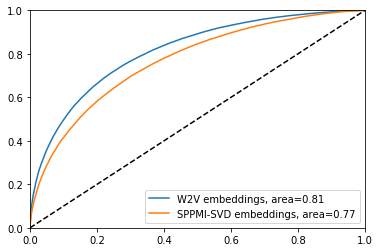

In [67]:
plt.figure(0).clf()

# ROC curve and AUC for Word2Vec
y_pred_w2v = Model_w2v.predict_proba(test_vecs_w2v)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_w2v)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="W2V embeddings, area={:.2f}".format(roc_auc))

# ROC curve and AUC for SPPMI - SVD
y_pred_svd = Model_svd.predict_proba(test_vecs_svd)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_svd)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="SPPMI-SVD embeddings, area={:.2f}".format(roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')
plt.show()

The ROC curves are very similar to each other and decent, the AUC for SPPMI - SVD is smaller though, 0.77 compared to 0.81.

Let's have look a the two confusion matrix.

* Word2Vec confusion matrix:

In [71]:
y_class_w2v = Model_w2v.predict(test_vecs_w2v)
print(classification_report(y_class_w2v, y_test))

              precision    recall  f1-score   support

           0       0.78      0.73      0.75    120415
           1       0.69      0.75      0.72     97385

    accuracy                           0.74    217800
   macro avg       0.73      0.74      0.73    217800
weighted avg       0.74      0.74      0.74    217800



An F1-score of 0.74, that's more than ok!

* SPPMI - SVD confusion matrix:

In [72]:
y_class_svd = Model_svd.predict(test_vecs_svd)
print(classification_report(y_class_svd, y_test))

              precision    recall  f1-score   support

           0       0.73      0.70      0.71    116868
           1       0.67      0.70      0.68    100932

    accuracy                           0.70    217800
   macro avg       0.70      0.70      0.70    217800
weighted avg       0.70      0.70      0.70    217800



If the precision, recall, f1-score are overall decent, they are lower than for Word2Vec, but only by a little bit.

# Conclusion

A brief recap of what we've done:
1. We used a 1.6 million tweets dataset to create both a Word2Vec and a SPPMI - SVD model
2. Using these models, we transformed the tweets into vectors
3. With these vectors in hand, we fed them to linear classifiers to predict the sentiment of each tweet
4. We compared the classification results obtained by Word2Vec and SPPMI - SVD word embeddings

We used both Word2Vec and SPPMI - SVD in their default mode, the tweets received only a light preprocessing, and we stuck to linear classifiers without any tuning. Still, in both cases, we got decent classification performance. Even better, SPPMI - SVD was very close to Word2Vec in term of Sentiment classification results.

**In the end, for this Sentiment Analysis task, SPPMI - SVD provides a decent alternative to Word2Vec**.

# Acknowledgement

* My implementation of SPPMI - SVD is very simple, if it were to be optimized (Numpy vectorization, multiprocessing or Cython code), it should produce word embeddings much faster than Word2Vec.

# References
* [1]. Mikolov et al. [*Efficient Estimation of Word Representations in Vector Space*](https://arxiv.org/pdf/1301.3781.pdf) 
* [2]. Mikolov et al. [*Distributed Representations of Words and Phrases and their Compositionality*](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
* [3].  Omer Levy and Yoav Goldberg [*Neural Word Embedding as Implicit Matrix Factorization*](https://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization.pdf)
* [4]. Ahmed Besbes [*Sentiment Analysis on twitter using word2vec and keras*](https://ahmedbesbes.com/sentiment-analysis-on-twitter-using-word2vec-and-keras.html)
* [5]. Sebastian Ruder [*On word embeddings - Part 3: The secret ingredients of word2vec*](http://ruder.io/secret-word2vec/)
* [6]. Chris Moody [*Stop Using Word2Vec*](https://multithreaded.stitchfix.com/blog/2017/10/18/stop-using-word2vec/)


# End